<img src="http://www.reeem.org/wp-content/uploads/2017/10/cropped-reeem-logo-transparent.png" width="300" style="float: left">
<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

# REEEM-DB - TIMESPanEU

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>

# Import

In [1]:
# basic
import sys
import os
import getpass
import pandas as pd
import numpy as np
import json
import pathlib
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v0.2.0'
project = 'REEEM'

# Database Connection

This function creates a database connection to the **reeem_db**.<br>
The default user is **reeem_vis**, a user that has only read rights.

This section establishes the database connection and asks for the **password**.<br>
The username can be changed in the corresponding function above.<br>
If you don't have a username or forgot your password please contact your database admins.

In [2]:
def reeem_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = '130.226.55.43' # input('host (default 130.226.55.43): ')
    port = '5432' # input('port (default 5432): ')
    database = 'reeem' # input("database name (default 'reeem'): ")
    user = 'reeem_vis' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

con = reeem_session()

D:\Anaconda3\envs\py36-reeem\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# Table Info

In [3]:
# Database
schema = 'model_draft'
table_in = 'reeem_times_paneu_input'
table_out = 'reeem_times_paneu_output'
folder = 'times_paneu'

pathlib.Path('data/'+folder).mkdir(parents=True, exist_ok=True) 
print("Database Schema:", schema +'\n'+ "Input table:", table_in +'\n'+ 
      "Output table:", table_out +'\n'+ "Created folder:", folder )

Database Schema: model_draft
Input table: reeem_times_paneu_input
Output table: reeem_times_paneu_output
Created folder: times_paneu


## Database Query

This section is used to query the database tables (**table_in** and **table_out**).<br>

In [4]:
# Number of entries in table
sql = text("""
    SELECT  'In' AS data, count(*) AS count
    FROM    {0}.{1}
    UNION ALL
    SELECT  'Out' AS data, count(*) AS count
    FROM    {0}.{2}""".format(schema, table_in, table_out))
df_num = pd.read_sql_query(sql, con)
df_num

,data,count
0,In,1416968
1,Out,9275010


In [5]:
# Pathways
column = 'pathway' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3} 
    ORDER BY {3}; """.format(schema, table_in, table_out, column))
df_path = pd.read_sql_query(sql, con)
df_path

,data,pathway,count
0,In,Base,1005528
1,Out,Base,3915408
2,Out,GHG,525102
3,In,HighRES,194012
4,Out,HighRES,1892493
5,Out,LocalSolutions,1050216
6,Out,LS,523668
7,Out,PA,524140
8,Out,Pilot,421992
9,In,Pilot,23416


In [6]:
# Versions
column = 'framework,pathway,version,updated' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3} 
    ORDER BY updated,{3}; """.format(schema, table_in, table_out, column))
df_ver = pd.read_sql_query(sql, con)
df_ver

,data,framework,pathway,version,updated,count
0,In,FrameworkV1,Pilot,DataV1,2017-10-27 00:00:00+02:00,23416
1,Out,FrameworkV1,Pilot,DataV1,2017-10-27 00:00:00+02:00,421992
2,Out,FrameworkV1,Base,DataV1,2017-11-15 00:00:00+01:00,420715
3,In,FrameworkV1,Base,DataV1,2017-11-15 00:00:00+01:00,194012
4,Out,FrameworkV1,HighRES,DataV1,2017-11-15 00:00:00+01:00,421991
5,In,FrameworkV1,HighRES,DataV1,2017-11-15 00:00:00+01:00,194012
6,Out,FrameworkV1,StorageInnov,DataV1,2017-11-15 00:00:00+01:00,421991
7,In,FrameworkV1,StorageInnov,DataV1,2017-11-15 00:00:00+01:00,194012
8,Out,FrameworkV1,Base,DataV2,2018-01-16 00:00:00+01:00,455031
9,In,FrameworkV1,Base,DataV2,2018-01-16 00:00:00+01:00,198044


In [7]:
# Years
column = 'year' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3} 
    ORDER BY {3} ; """.format(schema, table_in, table_out, column))
df_year = pd.read_sql_query(sql, con)
df_year

,data,year,count
0,Out,2015,1159334
1,In,2015,73381
2,Out,2020,1159382
3,In,2020,191941
4,In,2025,191941
5,Out,2025,1159385
6,In,2030,191941
7,Out,2030,1159382
8,Out,2035,1159381
9,In,2035,191941


In [8]:
# Regions
column = 'region' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3}
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3}; """.format(schema, table_in, table_out, column))
df_reg = pd.read_sql_query(sql, con)
df_reg

,data,region,count
0,In,IE,49882
1,In,LT,49882
2,In,ES,49874
3,In,CH,7220
4,In,MT,49770
5,In,IT,49882
6,In,BE,49874
7,In,AT,49866
8,In,LU,49810
9,In,SK,49866


In [9]:
# Categories
column = 'category' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3}; """.format(schema, table_in, table_out, column))
df_cat = pd.read_sql_query(sql, con)
df_cat

,data,category,count
0,In,Electrical efficiency of public power and CHP ...,2772
1,In,Service demands transport,26208
2,In,Lifetime of public power and CHP plants Gas co...,6930
3,In,Maximum electricity production of renewables,2800
4,In,Variable costs of storages,85536
5,In,Fix costs of public power and CHP plants Waste,2772
6,In,Electrical efficiency of public power and CHP ...,29106
7,In,Efficiency of public heating plants Coal,1386
8,In,Investment costs of public heating plants Coal,1386
9,In,Investment costs of public heating plants Sola...,2772


In [10]:
# Indicators
column = 'nid,category,indicator' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3}
    ORDER BY category, indicator, nid; """.format(schema, table_in, table_out, column))
df_nind = pd.read_sql_query(sql, con)
df_nind.index.names = ['rid']
df_nind

,data,nid,category,indicator,count
rid,,,,,
0,Out,1036.0,Activity Bus,Biodiesel,8
1,Out,1043.0,Activity Bus,Biodiesel,928
2,Out,1102.0,Activity Bus,Biodiesel,224
3,Out,1122.0,Activity Bus,Biodiesel,80
4,Out,1124.0,Activity Bus,Biodiesel,32
5,Out,1188.0,Activity Bus,Biodiesel,1448
6,Out,1190.0,Activity Bus,Biodiesel,896
7,Out,1191.0,Activity Bus,Biodiesel,952
8,Out,1039.0,Activity Bus,Combined Combustion,8


In [11]:
# Indicators
column = 'category,indicator' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3}
    ORDER BY category, indicator; """.format(schema, table_in, table_out, column))
df_ind = pd.read_sql_query(sql, con)
df_ind.index.names = ['rid']
df_ind

,data,category,indicator,count
rid,,,,
0,Out,Activity Bus,Biodiesel,4568
1,Out,Activity Bus,Combined Combustion,4568
2,Out,Activity Bus,Diesel,4568
3,Out,Activity Bus,Diesel hybrid,4568
4,Out,Activity Bus,Diesel PHEV,4568
5,Out,Activity Bus,DME,4568
6,Out,Activity Bus,Electricity,4568
7,Out,Activity Bus,Ethanol,4568
8,Out,Activity Bus,Ethanol hybrid,4568


In [12]:
# Write data as CSV file
csvname = 'data/{0}/reeem_{0}_indicators.csv'.format(folder)
df_ind.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

Data saved to file: data/times_paneu/reeem_times_paneu_indicators.csv


## Table metadata

Access the metadata from the database tables and write metadata string as JSON file.<br>

In [13]:
# Input Metadata
sql = text("""SELECT obj_description('{0}.{1}'::regclass);""".format(schema, table_in))
meta_in = pd.read_sql_query(sql, con).loc[:,'obj_description'].iloc[0]
print(meta_in)

# Save data to JSON file
fname_in = 'data/{0}/{1}_metadata.json'.format(folder, table_in)
with open(fname_in, 'w') as metafile:
    json.dump(json.loads(meta_in), metafile, indent=4)
    print("Data saved to file:", fname_in)

{"title": "REEEM Times PanEU Input",
    "description": "Input parameters: Service Demands, Fuel Prices, Potentials",
    "language": [ "eng" ],
    "spatial": 
        {"location": "none",
        "extent": "Europe",
        "resolution": "Country"},
    "temporal": 
        {"reference_date": "2010",
        "start": "2015",
        "end": "2050",
        "resolution": "5 years"},
    "sources": [
        {"name": "none", "description": "none", "url": "none", "license": "none", "copyright": "none"},
        {"name": "none", "description": "none", "url": "none", "license": "none", "copyright": "none"} ],
    "license":
        {"id": "none",
        "name": "none",
        "version": "none",
        "url": "none",
        "instruction": "none",
        "copyright": "none"},
    "contributors": [
        {"name": "Ludee", "email": "none", "date": "2016-12-01", "comment": "Create table"},
        {"name": "Ludee", "email": "none", "date": "2017-01-18", "comment": "Update metadata"},
   

In [14]:
# Output Metadata
sql = text("""SELECT obj_description('{0}.{1}'::regclass);""".format(schema, table_out))
meta_out = pd.read_sql_query(sql, con).loc[:,'obj_description'].iloc[0]
print(meta_out)

# Save data to JSON file
fname_out = 'data/{0}/{1}_metadata.json'.format(folder, table_out)
with open(fname_out, 'w') as metafile:
    json.dump(json.loads(meta_out), metafile, indent=4)
    print("Data saved to file:", fname_out)

{"title": "REEEM Times PanEU Output",
    "description": "Energy Consumption, Installed Capacities, Electricity Production, Heat Production, Fuel Input, Emissions, Mobility, Electricity Exchange",
    "language": [ "eng" ],
    "spatial": 
        {"location": "none",
        "extent": "Europe",
        "resolution": "Country"},
    "temporal": 
        {"reference_date": "2010",
        "start": "2010",
        "end": "2050",
        "resolution": "5 years"},
    "sources": [
        {"name": "TIMES PanEU", "description": "TIMES is an energy system model generator which is a further development of the model generators MARKAL and EFOM-ENV, written in GAMS. TIMES is a bottom-up linear optimization model based on a technical approach. The aim of the model is to optimize the energy system cost according to the given energy demands, energy technologies, and policy requirements. The Pan-European TIMES energy system model (TIMES PanEU) is a 30 region partial equilibrium energy system model. 

# View 1: One indicator for one region in one pathway over time
## Database Query

This section can be used to query one specific **indicator** (_filter 1_) for one specific **region** (_filter 2_) from one database table (_table_).<br>
Indicators are identified by the **nid**.<br>
It is possible to select one specific **pathway** (_filter 3_) and one specific data **version** (_filter 4_).<br>
To querry additional coulmns from the database table add the names to the **SELECT** statement (_column_).<br>
The sortation is done by the **ORDER BY** (_sorting_).<br>
The result from the database is saved to a pandas.DataFrame (**df_1**) and can be printed.

In [15]:
# Database select (SQL)
sql = text("""
    SELECT  pathway, version, region, year, category, indicator, value, unit  -- column
    FROM    {0}.{1}                               -- table
    WHERE   category = 'NEW Capacities Public and Industrial Power Plants by Fuel and Technology_Wind'
        AND indicator = 'Onshore'
        AND region = 'EU28'                       -- filter 2
        AND pathway = 'Base'                      -- filter 3
        AND framework = 'FrameworkV1'              
        AND version = 'DataV3'                    -- filter 4
    ORDER BY pathway, version, year;              -- sorting """.format(schema, table_out))
df_1 = pd.read_sql_query(sql, con)
print(df_1)

  pathway version region  year  \
0    Base  DataV3   EU28  2015   
1    Base  DataV3   EU28  2020   
2    Base  DataV3   EU28  2025   
3    Base  DataV3   EU28  2030   
4    Base  DataV3   EU28  2035   
5    Base  DataV3   EU28  2040   
6    Base  DataV3   EU28  2045   
7    Base  DataV3   EU28  2050   

                                            category indicator       value  \
0  NEW Capacities Public and Industrial Power Pla...   Onshore   64562.395   
1  NEW Capacities Public and Industrial Power Pla...   Onshore   15470.469   
2  NEW Capacities Public and Industrial Power Pla...   Onshore    7691.572   
3  NEW Capacities Public and Industrial Power Pla...   Onshore   24087.882   
4  NEW Capacities Public and Industrial Power Pla...   Onshore   51451.884   
5  NEW Capacities Public and Industrial Power Pla...   Onshore  120168.423   
6  NEW Capacities Public and Industrial Power Pla...   Onshore   75092.372   
7  NEW Capacities Public and Industrial Power Pla...   Onshore  10569

## Metadata

The important information from the above select (**df_1**) is collected in a Dictionary (**info_dict_1**).

In [16]:
# Facts dict
info_dict_1 = {}
info_dict_1['Filename'] = ['{}_reeem_plot_1' .format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict_1['Category'] = df_1.loc[:,'category'].unique()
info_dict_1['Indicator'] = df_1.loc[:,'indicator'].unique()
info_dict_1['Unit'] = df_1.loc[:,'unit'].unique()
info_dict_1['Pathway'] = df_1.loc[:,'pathway'].unique()
info_dict_1['Year'] = df_1.loc[:,'year'].unique().tolist()
info_dict_1['Region'] = df_1.loc[:,'region'].unique()
info_dict_1['Y-Axis'] = ['{} in {}'.format(*info_dict_1['Indicator'], *info_dict_1['Unit'])]
info_dict_1['Title'] = ['{} in {}'.format(*info_dict_1['Category'], *info_dict_1['Region'])]
info_dict_1['Metadata'] = meta_out

# Print facts
for x in info_dict_1:
    print(x,':',info_dict_1[x])

Filename : ['2019-07-16_reeem_plot_1']
Category : ['NEW Capacities Public and Industrial Power Plants by Fuel and Technology_Wind']
Indicator : ['Onshore']
Unit : ['MW']
Pathway : ['Base']
Year : [2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050]
Region : ['EU28']
Y-Axis : ['Onshore in MW']
Title : ['NEW Capacities Public and Industrial Power Plants by Fuel and Technology_Wind in EU28']
Metadata : {"title": "REEEM Times PanEU Output",
    "description": "Energy Consumption, Installed Capacities, Electricity Production, Heat Production, Fuel Input, Emissions, Mobility, Electricity Exchange",
    "language": [ "eng" ],
    "spatial": 
        {"location": "none",
        "extent": "Europe",
        "resolution": "Country"},
    "temporal": 
        {"reference_date": "2010",
        "start": "2010",
        "end": "2050",
        "resolution": "5 years"},
    "sources": [
        {"name": "TIMES PanEU", "description": "TIMES is an energy system model generator which is a further developmen

## Plot

This is a basic plot with [matplotlib](https://matplotlib.org/).<br>
The title and y-axis labels are taken from the **info_dict_1**. They can be exchanged with manual text.

D:\Anaconda3\envs\py36-reeem\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning:


The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.



(0, 125792.26555)

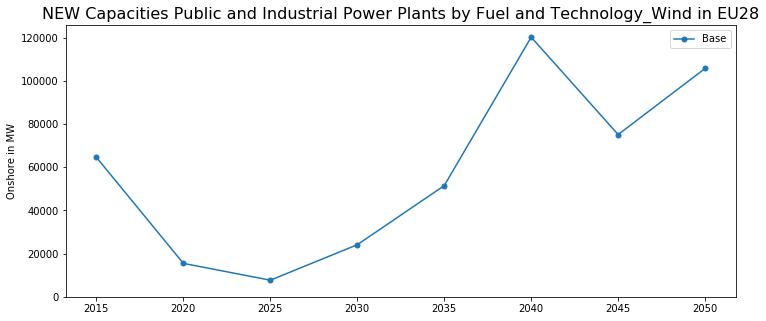

In [17]:
# Plot for one indicator and one pathway
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot()
# plt.title(r'CO2-Emissions in EU28', fontsize=16)  # Manual title
plt.title(*info_dict_1['Title'], fontsize=16)         # Title from info
# plt.ylabel(r'CO2-Emissions in Mt')                # Manual label
plt.ylabel(*info_dict_1['Y-Axis'])                    # Label from info
plt.plot(df_1.loc[:,'year'], df_1.loc[:,'value'], 
         marker="o",  markersize=5)
plt.legend(df_1.loc[:,'pathway'].unique())
ax.set_ylim(ymin=0)

## Interactive Plot

This is a basic interactive plot with [Plotly](https://plot.ly/python/).<br>
You can hover over the elements of the plot and observe the data.

In [18]:
# Interactive plot for one indicator and one pathway
data = [go.Scatter(
    x = df_1.loc[:,'year'],
    y = df_1.loc[:,'value'],
    name = df_1.loc[:,'pathway'].unique())]

# Set layout
layout = go.Layout(
    height=400, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_1['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_1['Y-Axis'])) )
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

ValueError: 
    Invalid value of type 'numpy.ndarray' received for the 'name' property of scatter
        Received value: array(['Base'], dtype=object)

    The 'name' property is a string and must be specified as:
      - A string
      - A number that will be converted to a string

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.

In [ ]:
# Save plot as file
plotname = ('data/' + str({0}) + '/' + str({1}) +'.png').format(folder, *info_dict_1['Filename'])
fig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

In [ ]:
# Write facts to textfile
txtname = ('data/' + str({0}) + '/' + str({1}) +'.txt').format(folder, *info_dict_1['Filename'])
with open(txtname,'w') as tfile:
    for i in info_dict_1.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict_1[i]]) + "\n")
tfile.close()
print("Facts saved to file:", txtname)

# Save data to CSV
csvname = ('data/' + str({0}) + '/' + str({1}) +'.csv').format(folder, *info_dict_1['Filename'])
df_1.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = ('data/' + str({0}) + '/' + str({1}) +'.png').format(folder, *info_dict_1['Filename'])
fig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = ('data/' + str({0}) + '/' + str({1}) +'.html').format(folder, *info_dict_1['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

# View 2: One indicator for one region in different pathways over time
## Database Query

This section can be used to query one specific **indicator** (_filter 1_) for one specific **region** (_filter 2_) from one database table (_table_).<br>
Indicators are identified by the **nid**.<br>
It is possible to select one specific **pathway** (_filter 3_) and one specific data **version** (_filter 4_).<br>
To querry additional coulmns from the database table add the names to the **SELECT** statement (_column_).<br>
The sortation is done by the **ORDER BY** (_sorting_).<br>
The result from the database is saved to a pandas.DataFrame (**df_2**) and can be printed.

In [ ]:
# Database select (SQL)
sql = text("""
    SELECT  pathway, version, region, year, category, indicator, value, unit  -- column
    FROM    {0}.{1}                               -- table
    WHERE   category = 'NEW Capacities Public and Industrial Power Plants by Fuel and Technology_Wind'
        AND indicator = 'Onshore'
        AND region = 'EU28'                       -- filter 2
        AND (pathway = 'Base' 
            OR pathway = 'HighRES')                       -- filter 3
        AND framework = 'FrameworkV1'              
        AND version = 'DataV3'                    -- filter 4
    ORDER BY pathway, version, year;              -- sorting """.format(schema, table_out))
df_2 = pd.read_sql_query(sql, con)
print(df_2)

In [ ]:
# Facts dict
info_dict_2 = {}
info_dict_2['Filename'] = ['{}_reeem_plot_2' .format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict_2['Category'] = df_2.loc[:,'category'].unique()
info_dict_2['Indicator'] = df_2.loc[:,'indicator'].unique()
info_dict_2['Unit'] = df_2.loc[:,'unit'].unique()
info_dict_2['Pathway'] = df_2.loc[:,'pathway'].unique()
info_dict_2['Year'] = df_2.loc[:,'year'].unique().tolist()
info_dict_2['Region'] = df_2.loc[:,'region'].unique()
info_dict_2['Y-Axis'] = ['{} in {}'.format(*info_dict_2['Indicator'], *info_dict_2['Unit'])]
info_dict_2['Title'] = ['{} in {}'.format(*info_dict_2['Category'], *info_dict_2['Region'])]
# ToDo: Select metadata string from database table and also add!

# Print facts
for x in info_dict_2:
    print(x,':',info_dict_2[x])

## Stack data

This pivot function reorganises the data and makes each pathway a column. The year is used as the index.<br>
The result is saved to a new dataframe (**df_2p**) and can be printed.

In [ ]:
# Reshape dataframe
df_2p = df_2.pivot(index='year', columns='pathway',  values='value')
# print (df_2p)

## Plot

This is a basic plot with [matplotlib](https://matplotlib.org/).<br>
The title and y-axis labels are taken from the **info_dict_2**. They can be exchanged with manual text.

In [ ]:
# Plot for one indicator and one pathway
fig_2 = plt.figure(figsize=(12, 5))
ax = plt.subplot()
# plt.title(r'CO2-Emissions in EU28', fontsize=16)  # Manual title
plt.title(*info_dict_2['Title'], fontsize=16)         # Title from info
# plt.ylabel(r'CO2-Emissions in Mt')                # Manual label
plt.ylabel(*info_dict_2['Y-Axis'])                    # Label from info
plt.plot(df_2p, 
         marker="o",  markersize=5)
plt.legend(df_2p)
ax.set_ylim(ymin=0)

## Interactive Plot

This is a basic interactive plot with [Plotly](https://plot.ly/python/).<br>
You can hover over the elements of the plot and observe the data.<br>
The different pathways can be switched on and off.

In [ ]:
# Iterate over pathways and add to data
pathways = df_2.loc[:,'pathway'].unique()
data = []
for pathway in pathways:
    data.append(go.Scatter(
        x = df_2.loc[df_2['pathway'] == pathway].loc[:,'year'],
        y = df_2.loc[df_2['pathway'] == pathway].loc[:,'value'],
        name = pathway))

# Set layout
layout = go.Layout(
    height=400, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_2['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_2['Y-Axis'])) )
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

## Interactive Plot 2

This is the manual interactive version.<br>
You can control the design using the [plotly documentation](https://plot.ly/python/line-and-scatter/#line-and-scatter-plots).

In [ ]:
data = [go.Scatter(x=df_2.loc[df_2['pathway'] == 'Base'].loc[:,'year'],
                   y=df_2.loc[df_2['pathway'] == 'Base'].loc[:,'value'],
                   mode='lines+markers',
                   line=dict(color='black', dash='none', width='2'),
                   marker=dict(symbol='o', size=8, line=dict(width=2, color='black')),
                   name='Base'
                  ),
        go.Scatter(x=df_2.loc[df_2['pathway'] == 'HighRES'].loc[:,'year'],
                   y=df_2.loc[df_2['pathway'] == 'HighRES'].loc[:,'value'],
                   mode='lines+markers',
                   line=dict(color='green', dash='', width='2'),
                   marker=dict(symbol='o', size=5, line=dict(width=2, color='black')),
                   name='HighRES'
                  ),
        go.Scatter(x=df_2.loc[df_2['pathway'] == 'StorageInnov'].loc[:,'year'],
                   y=df_2.loc[df_2['pathway'] == 'StorageInnov'].loc[:,'value'],
                   line=dict(color='red', dash='dash', width='2'),
                   marker=dict(symbol='o', size=5, line=dict(width=2, color='black')),
                   name='StorageInnov'
                  )
       ]
layout = go.Layout(
    height=400, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_2['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_2['Y-Axis'])) )
ifig2 = go.Figure(data=data, layout=layout)
pltly.iplot(ifig2)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.<br>

In [ ]:
# Write facts to textfile
filename = ('data/{}.txt').format(*info_dict_2['Filename'])
with open(filename,'w') as tfile:
    for i in info_dict_2.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict_2[i]]) + "\n")
tfile.close()
print("Facts saved to file:", filename)

# Save data to CSV
csvname = 'data/{}.csv' .format(*info_dict_2['Filename'])
df_2.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save pivot data to CSV
csvname = 'data/{}_pivot.csv' .format(*info_dict_2['Filename'])
df_2p.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict_2['Filename'])
fig_2.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict_2['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

# Save interactive plot 2
htmlname = 'data/{}_2.html' .format(*info_dict_2['Filename'])
pltly.plot(ifig2, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

# Download one pathway

In [ ]:
# Database select (SQL)
sql = text("""
    SELECT  *
    FROM    {0}.{1}
    WHERE   pathway = 'Base' 
            AND framework = 'FrameworkV1'              
            AND version = 'DataV3'
    ORDER BY nid, year;""".format(schema, table_out))
df_all = pd.read_sql_query(sql, con)
print(df_all)

In [ ]:
# Reshape dataframe
df_allp = df_all.pivot(index='year', columns='pathway',  values='value')
print (df_allp)

# Logging

In [ ]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "nb_name = '" + nb.notebook_path + "'";
kernel.execute(command);

In [ ]:
print(nb_name)

In [ ]:
# Database select (SQL)
sql = text("""
    -- scenario log (project,version,io,schema_name,table_name,script_name,comment)
    SELECT scenario_log('REEEM','v0.3.0','view','{0}','{1}','{2}',' ');
    """.format(schema, table_out, nb_name))
df_2 = pd.read_sql_query(sql, con)
print(df_2)